## Using Machine Learning to Identify Refugee Camps in the Middle East

### CNN Image Classification Problem 


Here the objective is to train a CNN on satellite images to identify refugee camps in the Middle East.  Here we are dealing with a real world problem and a limited amount of data.  We'll use a data augmentation feature to suplement our existing dataset.  

In [1]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import os, sys
import itertools, functools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight
from skimage.io import imread, imshow
from skimage.transform import resize

# Random seed for numpy
np.random.seed(18937)
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

import os
import argparse
from shutil import copy
from pathlib import Path
from multiprocessing import Pool, TimeoutError

Using TensorFlow backend.


### Project Staging 

### Let's examine some of the actual images 

Showing the train/camp karkamis image, full path : /dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train/camp/camp,karkamis,38.02801,36.87465-chip13.png


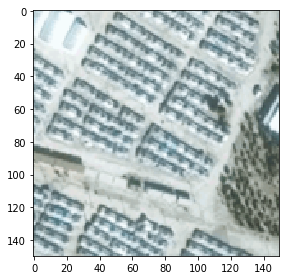

In [3]:
DATASET = lambda fname = '': os.path.join('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train', fname)
assert os.path.exists(DATASET())

plt.figure()

print("Showing the train/camp karkamis image, full path : {}".format(
            DATASET('camp/camp,karkamis,38.02801,36.87465-chip13.png')
        )
     )

imshow(imread(DATASET('camp/camp,karkamis,38.02801,36.87465-chip13.png')))

#### Take a look at one of the noncamp images 


(150, 150, 3)

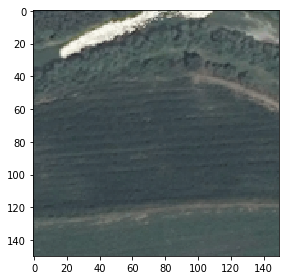

In [4]:
imshow(imread(DATASET('noncamp/noncamp,apaydin,36.35856,36.23933-chip05.png')))
imread(DATASET('noncamp/noncamp,apaydin,36.35856,36.23933-chip05.png')).shape

In [5]:
## Here we have staged some data for testing a model.  We'll count the images here.  

import os

# count instances of noncamp in our training directory
DIR = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train/noncamp'
print("Noncamp Training Images:",len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

# count instances of camp in our training directory
DIR = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train/camp'
print("Camp Training Images:",len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


# count instances of noncamp in our testing directory
DIR = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp'
print("Noncamp Test Images",len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

# count instances of camp in our testing directory
DIR = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp'
print("Camp Test Images:",len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


Noncamp Training Images: 80
Camp Training Images: 28
Noncamp Test Images 40
Camp Test Images: 11


## Build our CNN Model 




In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

z = load_img('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp/noncamp,altinozu,36.35925,36.17987-chip10.png')  # this is a PIL image
x = img_to_array(z)  # this is a Numpy array with shape (3, 150, 150)
print(x.shape)

n_col = x.shape
print(n_col)

xt = np.transpose(x)
inputs = Input(shape=(784,))

n_col

(150, 150, 3)
(150, 150, 3)


(150, 150, 3)

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(n_col))) # n_col is defined by the shape above 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [8]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
batch_size = 50

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')


Found 108 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [10]:
# since we're dealing with a class imballance we're going to weight classes

#There are 74% images which are class 1, and 26% images which are class 0.  
#I balance 2 classes using the class_weights
class_weights = {0:74,1:26}

model.fit_generator(
        train_generator,
        steps_per_epoch=2881 // batch_size,
        epochs=10,
        class_weight=class_weights,
        validation_data=validation_generator,
        validation_steps=1184 // batch_size)
# model.save_weights('first_try.h5')  #  save weights after training or during training

Epoch 1/10
57/57 [==============================] - 112s - loss: 20.5354 - acc: 0.6505 - val_loss: 0.2944 - val_acc: 0.9018
Epoch 2/10
57/57 [==============================] - 104s - loss: 10.4626 - acc: 0.9162 - val_loss: 0.2193 - val_acc: 0.9021
Epoch 3/10
57/57 [==============================] - 106s - loss: 3.8237 - acc: 0.9687 - val_loss: 0.1497 - val_acc: 0.9609
Epoch 4/10
57/57 [==============================] - 109s - loss: 2.3353 - acc: 0.9844 - val_loss: 0.1703 - val_acc: 0.9413
Epoch 5/10
57/57 [==============================] - 108s - loss: 1.5189 - acc: 0.9851 - val_loss: 0.1956 - val_acc: 0.9413
Epoch 6/10
57/57 [==============================] - 107s - loss: 4.3193 - acc: 0.9591 - val_loss: 0.2360 - val_acc: 0.9609
Epoch 7/10
57/57 [==============================] - 107s - loss: 1.8416 - acc: 0.9804 - val_loss: 0.1333 - val_acc: 0.9609
Epoch 8/10
57/57 [==============================] - 107s - loss: 1.5238 - acc: 0.9901 - val_loss: 0.2655 - val_acc: 0.9395
Epoch 9/10
57/

In [11]:
model.save_weights('first_try.h5')  #  save weights after training or during training
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [12]:
validation_generator.class_indices # check class indicies 

{'camp': 0, 'noncamp': 1}

## Model Evaluation

### Look at what the model is predicting 

Here we will load up some of the testing images and see if the model predicts that there is a refugee camp present or if there is no refugee camp.  

But first check the model accuracy and loss/error.  We will evaluate the model using  **validation_generator** to provide data.

In [13]:
loss, accuracy = model.evaluate_generator(validation_generator, steps = 800 // batch_size)
print('loss:', loss, 'accuracy:', accuracy)

loss: 0.239554795581 accuracy: 0.941176468251


50/50 [==============================] - 0s     
[[ 8  2]
 [ 1 39]]


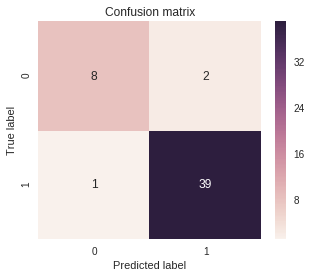

In [14]:
for batch in itertools.islice(validation_generator, 200):
    X_test, y_test = batch

y_preds = model.predict(X_test)
#y_preds = np.argmax(y_pred, axis=1) + 1

#print(y_preds)
predictions = model.predict_classes(X_test)
#print(predictions2)

preds = []
for i in predictions:
    preds.extend(i)

classification_report(y_test, preds)
cm = confusion_matrix(y_test, preds)
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [15]:
report = classification_report(y_test, preds)
print(report)

             precision    recall  f1-score   support

        0.0       0.89      0.80      0.84        10
        1.0       0.95      0.97      0.96        40

avg / total       0.94      0.94      0.94        50



0.8875


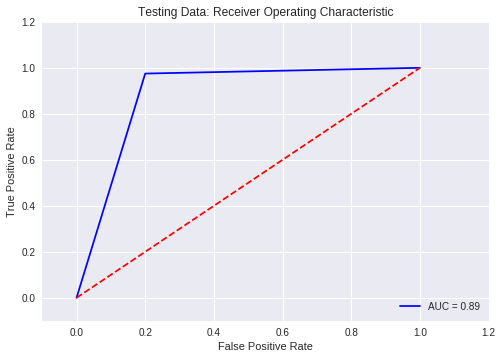

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

####ROC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

plt.title('Testing Data: Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Test the model on some images 

Now let's see images and the predicted labels 

Model Prediction: Refugee Camp


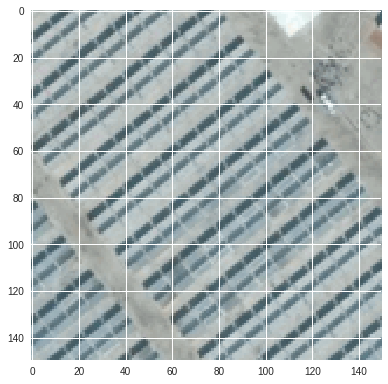

In [17]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,malatya_beydagi,38.15119,38.33874-chip02.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Model Prediction: Noncamp


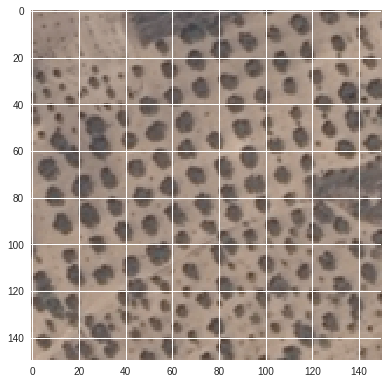

In [18]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp/noncamp,altinozu,36.35925,36.17987-chip10.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Model Prediction: Refugee Camp


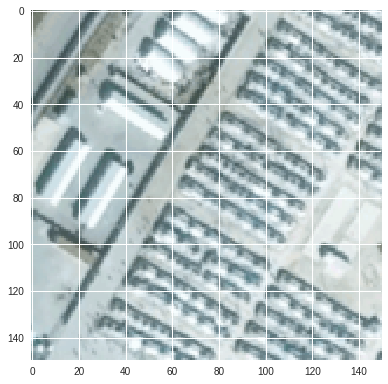

In [19]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,karkamis,38.02801,36.87465-chip06.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Model Prediction: Noncamp


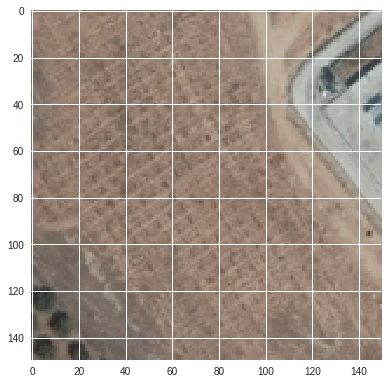

In [20]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,malatya_beydagi,38.15119,38.33874-chip00.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


The image above shows a small corner of a refugee camp.  Looks like there is just not enough features for the model to pick up that there is a refugee camp present in this image. 

Model Prediction: Noncamp


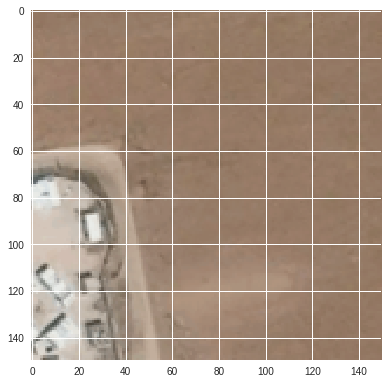

In [21]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,king_abdullah_park,36.02617,32.52987-chip16.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Here we pull up another image where there's only a small portion of a refugee camp.  In this image the refugee camp is slightly more in the frame than the previous image, but it is still hard to tell that there is a refugee camp present.  In this situation the model predicts that there is no refugee camp present.  

Model Prediction: Refugee Camp


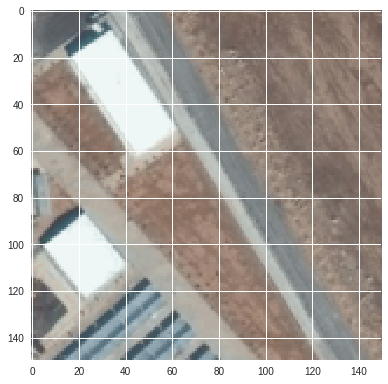

In [22]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,malatya_beydagi,38.15863,38.33874-chip06.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


The above image is a coner of a refugee camp.  It is hard to clearly tell if there is a refugee camp present in the image as not all the tents and lines are clear.  In this situation the model predicts that there is a refugee camp present.   

### Thoughts and Next Steps 

This project tests the idea that we can build a classifier to identify refugee camps.  Here we are using a small number of images which is common when working with satellite data.  In the notebook I built a simple model and got pretty good results.  We notice the model tends to fail when small portions of the refugee camp are in the image.  Going forward we might need build a three class model.  

Some other potential issues with the model might include the fact that we trained it based on the geography of the Middle East.  Most of these images are from areas near refugee camps in Iraq, Turkey and Jordan.  Therefore our noncamp categories generally represent arid environments. This might cause problems if we started feeding the model images from different types of environments - even environments that are semi-urban.  Ultimately, we would want to outline all of these assumptions and test the model againt them to better understand where our model works best and where it performs poorly. This step is an important part of data science when dealing with real world problems. 

In conclusion it is possible to build a CNN to discover refugee camps.  

#### Next Steps 

Estimate camp population using Satellite data.  We can grab more images for this next step.  Ideally, we are going to need to get images that somewhat align with the UNHCR data which has population counts for the camps.  

Special thanks to the Digital Globe Foundation 

http://foundation.digitalglobe.com/